In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)

from box_horizontal_operations import (merge_horizontal_blocks)
from box_grouping import arrange_grouped_line_indices

from box_font_evalutions import (are_lines_fonts_similar)
from box_vertical_evalutions import (are_vlines)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy


## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [3]:
base_dir   = '/Users/kd/Workspace/python/github/document-structure/data'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'


In [4]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
print(xml_files, "\n\n")

image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
print(image_files)

Extracted pdf images [/Users/kd/Workspace/python/github/document-structure/data/output/20695_2010_8_1501_20635_Judgement_17-Feb-2020/images] 


Extracted xml of digital PDF [/Users/kd/Workspace/python/github/document-structure/data/output/20695_2010_8_1501_20635_Judgement_17-Feb-2020/pdttohtml] 


['/Users/kd/Workspace/python/github/document-structure/data/output/20695_2010_8_1501_20635_Judgement_17-Feb-2020/pdttohtml/20695_2010_8_1501_20635_Judgement_17-Feb-2020.xml'] 


['/Users/kd/Workspace/python/github/document-structure/data/output/20695_2010_8_1501_20635_Judgement_17-Feb-2020/images/20695_2010_8_1501_20635_Judgement_17-Feb-20200001-01.jpg', '/Users/kd/Workspace/python/github/document-structure/data/output/20695_2010_8_1501_20635_Judgement_17-Feb-2020/images/20695_2010_8_1501_20635_Judgement_17-Feb-20200001-02.jpg', '/Users/kd/Workspace/python/github/document-structure/data/output/20695_2010_8_1501_20635_Judgement_17-Feb-2020/images/20695_2010_8_1501_20635_Judgement_17-Feb-202000

In [5]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (54) in file (20695_2010_8_1501_20635_Judgement_17-Feb-2020.xml)


In [6]:
document_configs = {
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

## Vertical box merging operations

In [7]:
def merge_vertical_blocks(in_df, configs, debug=False):
    df                 = in_df.copy(deep=True)
    df                 = in_df.reset_index(drop=True)
    
    connections        = []
    index_grams        = get_ngram(list(df.index.values), window_size=2)
    
    for index_gram in index_grams:
        if are_lines_fonts_similar(df, configs, index_gram[0], index_gram[1], debug=debug):
            connections.append((index_gram[1], index_gram[0], 'CONNECTED'))
        else:
            connections.append((index_gram[1], index_gram[0], 'NOT_CONNECTED'))

    if debug:
        print("block connections (get_document_horizontal_blocks) : %s \n----\n" % (str(connections)))
        
    grouped_lines   = arrange_grouped_line_indices(connections, debug=debug)
    cols            = df.columns.values.tolist()
    
    if 'children' not in cols:
        cols.append('children')
        
    block_df        = pd.DataFrame(columns=cols)
    
    index           = 0
    for lines in grouped_lines:
        line_indices, connection_type = lines
        if connection_type == 'NOT_CONNECTED':
            for line_index in line_indices:
                block_df.loc[index] = df.iloc[line_index]
                block_df.loc[index]['children'] = None
                index += 1
        else:
            children_df  = df.loc[lines[0][0]:lines[0][-1]].copy(deep=True)
            top          = children_df['text_top'].min()
            left         = children_df['text_left'].min()
            width        = children_df[['text_left', 'text_width']].sum(axis=1).max() - left

            children_df.sort_values('text_top', axis = 0, ascending = True, inplace=True)
            height       = (children_df.iloc[-1]['text_top'] + children_df.iloc[-1]['text_height']) - children_df['text_top'].min()
            
            block_df.at[index, 'text_top']     = top
            block_df.at[index, 'text_left']    = left
            block_df.at[index, 'text_height']  = height
            block_df.at[index, 'text_width']   = width
            
            block_df.at[index, 'text']         = ' '.join(children_df['text'].values.tolist())

            block_df.at[index, 'xml_index']    = children_df['xml_index'].min()
            block_df.at[index, 'font_size']    = children_df['font_size'].max()
            block_df.at[index, 'font_family']  = df.iloc[lines[0][0]]['font_family']
            block_df.at[index, 'font_color']   = df.iloc[lines[0][0]]['font_color']
            block_df.at[index, 'children']     = children_df.to_json()
            index += 1
    
    return block_df


In [8]:
file_index = 0

img        = image_files[file_index]
df         = xml_dfs[file_index]


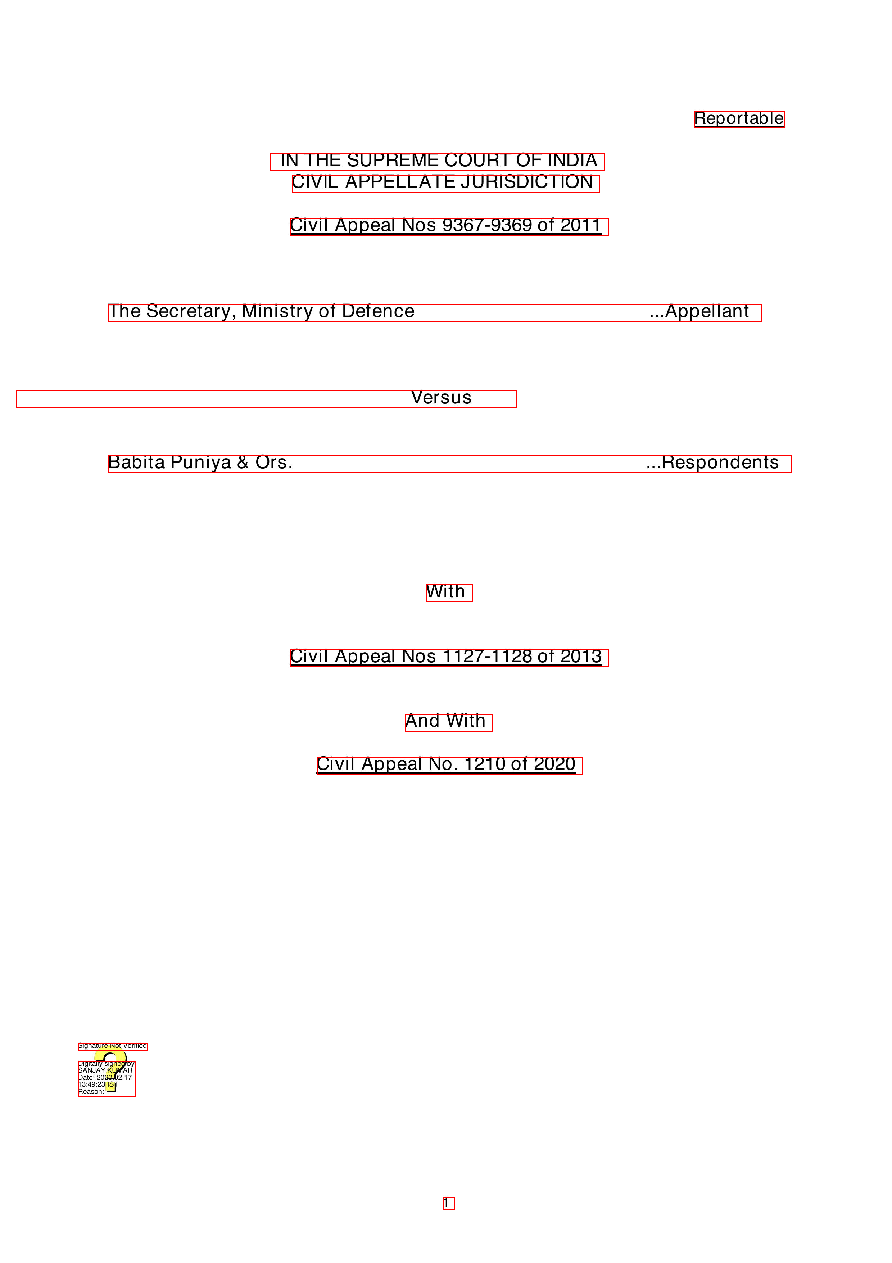

In [12]:
h_df    = merge_horizontal_blocks(df, document_configs, debug=False)

in_h_df = h_df #.loc[11:12]
v_df    = merge_vertical_blocks(in_h_df, document_configs, debug=False)

draw_box(img, page_width, page_height, h_df, color='red')
# show_df(in_h_df)

In [10]:
show_df(in_h_df)

NameError: name 'in_h_df' is not defined